# ARC AGI with Llama 3.2 1B - Test-time Fine-tuning

In [2]:
from helper import clear_old_model_refs
from dataloader import get_arc_datasets
arc_train, arc_eval = get_arc_datasets()

print(f"Loaded {len(arc_train):,} training tasks and {len(arc_eval):,} evaluation tasks.")

Loaded 1,076 training tasks and 172 evaluation tasks.


Selecting inner index 0


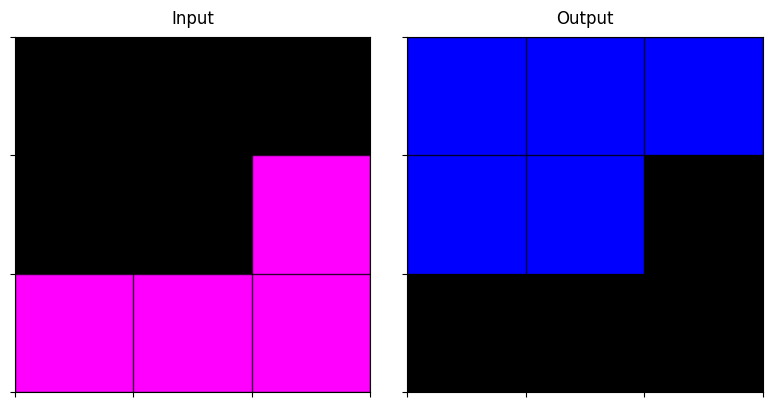

In [3]:
from plot import plot_grid
import matplotlib.pyplot as plt

challenge_index = 450
challenge_split = 'train' # train or test
split_index = 0
type = 'input' # input or output

challenge = arc_train[challenge_index]
print(f"Selecting inner index {split_index}")

challenge_split = challenge[challenge_split]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_grid(challenge_split[split_index]['input'],  'Input',  ax=axes[0])
plot_grid(challenge_split[split_index]['output'], 'Output', ax=axes[1])
plt.tight_layout()
plt.show()

grid = challenge_split[split_index][type]

In [4]:
from dataloader import prepare_evaluation_dataset
# Build the evaluation set (no augmentation, *with* test examples)
eval_dataset = prepare_evaluation_dataset(
    arc_eval,
)
print(eval_dataset)

Dataset({
    features: ['file_name', 'messages'],
    num_rows: 172
})


In [5]:
output_dir = "./model/gpt2-2000" 

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch

print(f"Loading fine-tuned model from {output_dir}...")

try:
    # 重新載入 base model
    base_model_name = "gpt2"
    base_model = AutoModelForCausalLM.from_pretrained(base_model_name)
    
    # 載入 tokenizer
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    tokenizer.pad_token = tokenizer.eos_token
    
    # 載入 LoRA adapter
    model = PeftModel.from_pretrained(base_model, output_dir)
    
    # 確保模型在正確的設備上
    device = torch.device("cpu")  # 使用 CPU
    model = model.to(device)
    
    print("✓ Fine-tuned model loaded successfully from saved checkpoint")
    print(f"✓ Model is on device: {next(model.parameters()).device}")
    
    # 驗證模型參數
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    print(f"✓ Model parameters - Trainable: {trainable_params:,}, Total: {all_params:,}")
    
except Exception as e:
    print(f"❌ Error loading model from {output_dir}: {e}")
    print("Make sure the model was saved correctly in previous steps.")
    raise

Loading fine-tuned model from ./model/gpt2-2000...
'NoneType' object has no attribute 'cadam32bit_grad_fp32'
✓ Fine-tuned model loaded successfully from saved checkpoint
✓ Model is on device: cpu
✓ Model parameters - Trainable: 0, Total: 125,250,816


/Users/coconut/arc-agi/.venv/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [7]:
import re
import json
import numpy as np

def parse_grid_from_text(text):
    """
    從模型生成的文本中解析網格
    嘗試找到格式化的網格表示
    """
    # 查找可能的網格表示
    grid_patterns = [
        r'\[\[(.*?)\]\]',  # [[1,2,3],[4,5,6]]
        r'Grid:\s*\[(.*?)\]',  # Grid: [...]
        r'Output:\s*\[(.*?)\]',  # Output: [...]
        r'Result:\s*\[(.*?)\]',  # Result: [...]
    ]
    
    for pattern in grid_patterns:
        matches = re.search(pattern, text, re.DOTALL)
        if matches:
            try:
                # 嘗試解析為 JSON
                grid_str = '[' + matches.group(1) + ']'
                grid = json.loads(grid_str)
                return np.array(grid)
            except:
                continue
    
    # 如果無法解析，返回空網格
    return np.array([[0]])

def generate_arc_solution(eval_example, max_retries=3):
    """
    使用訓練好的模型生成 ARC 任務的解決方案
    """
    # 從 eval_example 構建提示
    messages = eval_example['messages']
    
    # 構建完整的提示文本
    prompt_text = ""
    for msg in messages[:-1]:  # 排除最後一個助手回應
        role = msg.get('role', '')
        content = msg.get('content', '')
        prompt_text += f"{role}: {content}\n"
    
    # 添加助手開頭
    prompt_text += "assistant:"
    
    for attempt in range(max_retries):
        try:
            # 生成回應
            inputs = tokenizer(prompt_text, return_tensors="pt").to(device)
            
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_length=inputs['input_ids'].shape[1] + 200,
                    num_beams=2,
                    temperature=0.7,
                    do_sample=True,
                    pad_token_id=tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    repetition_penalty=1.2
                )
            
            # 解碼生成的文本
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            assistant_response = generated_text[len(prompt_text):].strip()
            
            # 嘗試從生成的文本中解析網格
            predicted_grid = parse_grid_from_text(assistant_response)
            
            return assistant_response, predicted_grid
            
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt == max_retries - 1:
                return f"Generation failed after {max_retries} attempts", np.array([[0]])
    
    return "Failed to generate", np.array([[0]])

print("✓ Grid parsing and solution generation functions ready")

✓ Grid parsing and solution generation functions ready


Testing model on 1 examples from arc_eval...

Testing Example 1/1
Input grid shape: (30, 30)
True output shape: (9, 3)
Could not parse prediction, using random grid for visualization


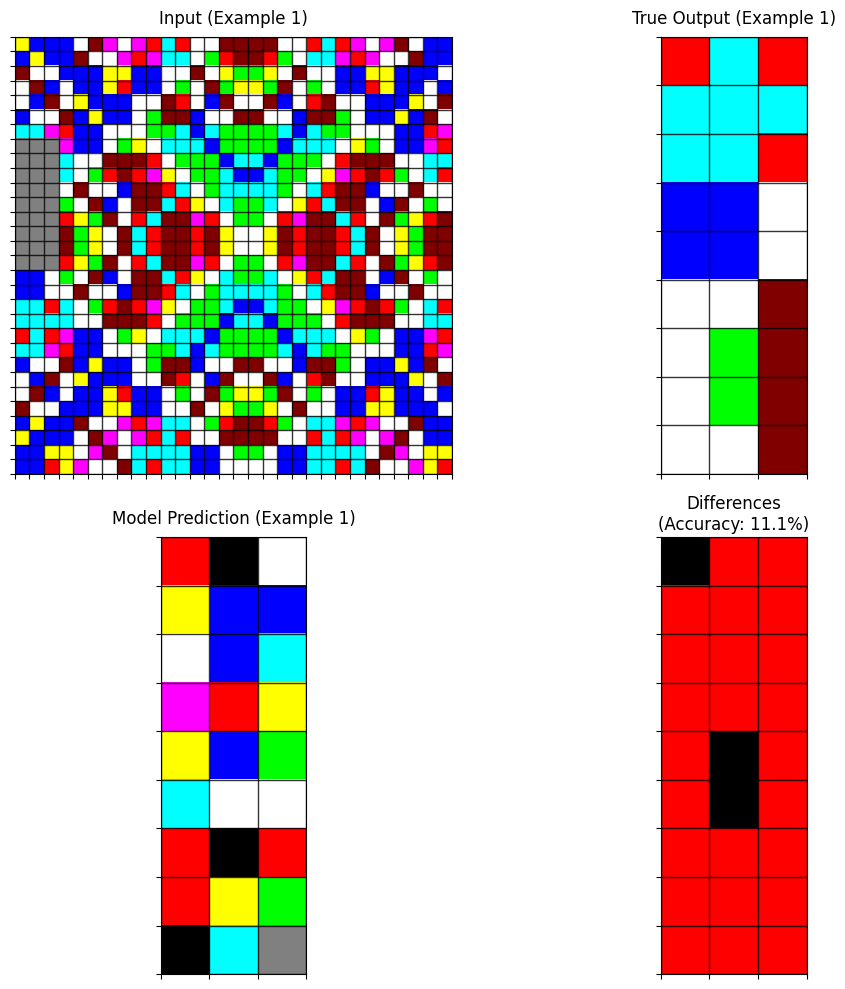


Model Response:
''


In [8]:
def test_model_with_arc_data(num_examples=3):
    """
    使用原始 ARC 數據進行測試，確保能獲得正確的真實答案
    """
    print(f"Testing model on {num_examples} examples from arc_eval...")
    
    # 從 arc_eval 中選擇測試例子
    test_indices = range(min(num_examples, len(arc_eval)))
    
    for idx in test_indices:
        print(f"\n{'='*60}")
        print(f"Testing Example {idx + 1}/{num_examples}")
        print(f"{'='*60}")
        
        # 獲取原始 ARC 數據
        arc_task = arc_eval[idx]
        
        # 提取測試例子（通常在 'test' 字段中）
        if 'test' in arc_task and len(arc_task['test']) > 0:
            test_case = arc_task['test'][0]  # 使用第一個測試案例
            input_grid = np.array(test_case['input'])
            true_output = np.array(test_case['output'])
            
            # 構建簡化的提示
            prompt = f"user: Given the input grid {input_grid.tolist()}, what should be the output?\nassistant:"
            
            print(f"Input grid shape: {input_grid.shape}")
            print(f"True output shape: {true_output.shape}")
            
            # 生成模型預測
            try:
                inputs = tokenizer(prompt, return_tensors="pt", max_length=500, truncation=True).to(device)
                
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_length=inputs['input_ids'].shape[1] + 100,
                        num_beams=1,
                        temperature=0.8,
                        do_sample=True,
                        pad_token_id=tokenizer.eos_token_id,
                        eos_token_id=tokenizer.eos_token_id,
                    )
                
                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                response = generated_text[len(prompt):].strip()
                
                # 嘗試解析預測網格
                predicted_grid = parse_grid_from_text(response)
                
                # 如果解析失敗，創建一個隨機網格作為示例
                if predicted_grid.shape == (1, 1) and predicted_grid[0, 0] == 0:
                    predicted_grid = np.random.randint(0, 10, size=true_output.shape)
                    print("Could not parse prediction, using random grid for visualization")
                
            except Exception as e:
                print(f"Generation error: {e}")
                predicted_grid = np.zeros_like(true_output)
                response = f"Generation failed: {e}"
            
            # 創建可視化
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # 繪製輸入
            plot_grid(input_grid, f'Input (Example {idx + 1})', ax=axes[0, 0])
            
            # 繪製真實輸出
            plot_grid(true_output, f'True Output (Example {idx + 1})', ax=axes[0, 1])
            
            # 繪製模型預測
            plot_grid(predicted_grid, f'Model Prediction (Example {idx + 1})', ax=axes[1, 0])
            
            # 繪製差異
            if predicted_grid.shape == true_output.shape:
                diff_grid = (predicted_grid != true_output).astype(int)
                plot_grid(diff_grid, f'Differences', ax=axes[1, 1])
                accuracy = np.mean(predicted_grid == true_output) * 100
                axes[1, 1].set_title(f'Differences\n(Accuracy: {accuracy:.1f}%)', fontsize=12)
            else:
                axes[1, 1].text(0.5, 0.5, f'Shape mismatch:\nPred: {predicted_grid.shape}\nTrue: {true_output.shape}', 
                               ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=10)
                axes[1, 1].set_title(f'Shape Mismatch', fontsize=12)
            
            plt.tight_layout()
            plt.show()
            
            # 顯示模型響應
            print(f"\nModel Response:")
            print(f"'{response[:150]}...' " if len(response) > 150 else f"'{response}'")
            
        else:
            print(f"No test data found for example {idx + 1}")

test_model_with_arc_data(num_examples=1)